<a href="https://colab.research.google.com/github/rgmantovani/advancedML/blob/master/codes/aula_04_rnns_ltsm/LSTM_example1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso de Deep Learning para Séries Temporais (LSTMs)

Disciplina: Métodos e Modelos Avançados em Ciência de Dados

Especialização em Ciência de Dados - Universidade Tecnologica Federal do Paraná

Aula 04: RNNs e LSTMs

Exemplo 01: Executando LSTM para série temporal univariada (shampoo)

---

In [24]:
# importando as bibliotecas necessárias para rodar o script

# manipulação de números de ponto flutuante
import numpy as np

# plotagem de gráficos
import matplotlib.pyplot as plt

# criação manipulação de data frames
import pandas as pd

# funções matemáticas
import math

# criação dos modelos de DL
from keras.models import Sequential

from keras.layers import Dense
from keras.layers import LSTM

# preprocessador - escalar os dados
from sklearn.preprocessing import MinMaxScaler

# metrica de desempenho (MSE)
from sklearn.metrics import mean_squared_error

In [25]:
# definir um seed para reprodução dos experimentos
np.random.seed(42)

In [26]:
# obter dataset --> https://github.com/jbrownlee/Datasets
# Exemplo: shampoo, venda de shampoos ao longo de três anos
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv"

# ler como data frame (via pandas)
dataframe = pd.read_csv(url, header=0, usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')

# vislumbrar um pedaço dos dados e formato lido
print("\n* Dimensão dos dados:", dataset.shape) 
# 36 amostras/instâncias, univariadas (um único valor real)
print("* Dados originais:")
print(dataset[:10])


* Dimensão dos dados: (36, 1)
* Dados originais:
[[266. ]
 [145.9]
 [183.1]
 [119.3]
 [180.3]
 [168.5]
 [231.8]
 [224.5]
 [192.8]
 [122.9]]


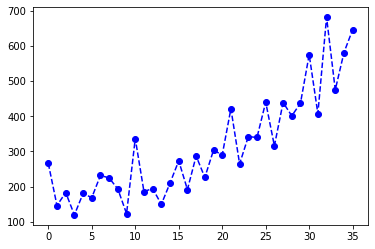

In [27]:
# plotar os dados para visualizar a nossa time series
plt.plot(dataset, linestyle='--', marker='o', color='b')

Temos dados com valores variados, mas precisamos escalar a série temporal no intervalo [-1,+1], que é o intervalo de saída da função de ativação que usaremos. 

In [28]:
# Normalizando os dados

# escalar os dados no intervalo [-1,1] usando sklearn
# from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)

print("* Dados escalados:")
print(dataset[:10].transpose())

* Dados escalados:
[[-0.47858536 -0.9054558  -0.7732361  -0.99999994 -0.78318816 -0.8251288
  -0.6001421  -0.62608844 -0.7387595  -0.9872045 ]]


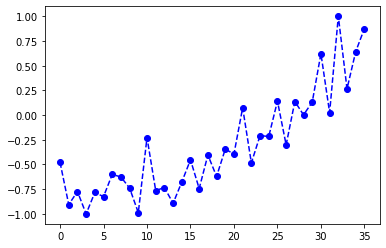

In [29]:
# visualizar nossos dados escalados
# Obs: prestar atenção ao eixo Y, agora varia entre [-1,+1]
plt.plot(dataset, linestyle='--', marker='o', color='b')

In [30]:
# funcao auxiliar para criar os itervalos de previsao
def create_dataset(dataset, janela_previsao=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-janela_previsao-1):
        a = dataset[i:(i+janela_previsao), 0]
        dataX.append(a)
        dataY.append(dataset[i + janela_previsao, 0])
    return np.array(dataX), np.array(dataY)

In [31]:
# Ajustando conjunto de treino e teste
# 85% dos exemplos no treino, 15% no teste
train_size = int(len(dataset) * 0.85)
test_size  = len(dataset) - train_size

#print(train_size, test_size)
print("- Numero de instâncias treino: ", train_size)
print("- Numero de instâncias teste: ", test_size)

- Numero de instâncias treino:  30
- Numero de instâncias teste:  6


In [32]:
# Conjunto de treinamento - amostras de 0-29
# Conjunto de teste - amostras de 30-35
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print("* Conjunto de Treinamento:", train.shape)
#print(train)

print("* Conjunto de Teste:", test.shape)
#print(test)

* Conjunto de Treinamento: (30, 1)
* Conjunto de Teste: (6, 1)


In [33]:
# reshape em X=t and Y=t+1
# isto é, criando dados no padrão DF = [X|Y]
# para cada X, o Y = X+1

janela_previsao = 1
trainX, trainY = create_dataset(train, janela_previsao)

# vendo o nosso conjunto de treinamento
print("DF = [X | X+1]")
np.column_stack((trainX, trainY))

DF = [X | X+1]


array([[-0.47858536, -0.9054558 ],
       [-0.9054558 , -0.7732361 ],
       [-0.7732361 , -0.99999994],
       [-0.99999994, -0.78318816],
       [-0.78318816, -0.8251288 ],
       [-0.8251288 , -0.6001421 ],
       [-0.6001421 , -0.62608844],
       [-0.62608844, -0.7387595 ],
       [-0.7387595 , -0.9872045 ],
       [-0.9872045 , -0.2280078 ],
       [-0.2280078 , -0.76328415],
       [-0.76328415, -0.73342806],
       [-0.73342806, -0.8926603 ],
       [-0.8926603 , -0.67727023],
       [-0.67727023, -0.45263904],
       [-0.45263904, -0.74373555],
       [-0.74373555, -0.4039452 ],
       [-0.4039452 , -0.62075704],
       [-0.62075704, -0.344944  ],
       [-0.344944  , -0.39363778],
       [-0.39363778,  0.07446253],
       [ 0.07446253, -0.48391676],
       [-0.48391676, -0.20739293],
       [-0.20739293, -0.21663404],
       [-0.21663404,  0.14128315],
       [ 0.14128315, -0.30122626],
       [-0.30122626,  0.13737333],
       [ 0.13737333,  0.00231028]], dtype=float32)

In [34]:
# reshape em X=t and Y=t+1 para o conjunto de teste

testX, testY  = create_dataset(test, janela_previsao)
print("Conjunto de Teste no formato supervisionado:")
print(testX)
print("Conjunto de Teste no formato supervisionado:")
print(testY)
print("\nDF = [X | X+1]")
np.column_stack((testX, testY))

Conjunto de Teste no formato supervisionado:
[[0.62146807]
 [0.02470243]
 [1.        ]
 [0.26532793]]
Conjunto de Teste no formato supervisionado:
[0.02470243 1.         0.26532793 0.6420827 ]

DF = [X | X+1]


array([[0.62146807, 0.02470243],
       [0.02470243, 1.        ],
       [1.        , 0.26532793],
       [0.26532793, 0.6420827 ]], dtype=float32)

In [35]:
# Ajustando os conjunto de treino (trainX) e teste (testX) para o formato
# [samples, time_steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
print("- Dim train:", trainX.shape)
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print("- Dim test:  ", testX.shape)

print("Teste no formato para input:") #alternativamente poderíamos ter amostras multivariadas
print(testX)

- Dim train: (28, 1, 1)
- Dim test:   (4, 1, 1)
Teste no formato para input:
[[[0.62146807]]

 [[0.02470243]]

 [[1.        ]]

 [[0.26532793]]]


In [36]:
# Criando nossa rede recorrente com unidades de LSTM 

# formato keras sequencial
model = Sequential()

# camada recorrente com 4 blocos/neurônios, amostra única (1) 
# para prever a janela de previsão = 1
# assim, input_shape = (1, 1)
model.add(LSTM(units=4, input_shape=(1, janela_previsao))) 
# Add um layer, completamente conectado para agregar a saida dos 4 neuronios
model.add(Dense(1))

# visualizar o modelo (arquitetura) que geramos
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [37]:
# parâmetros para otimizacao
# medida a ser minimizada = Erro quadrático médio (Mean Squared Error)
# Otimizador, algoritmo de treinamento = Adam
# métricas para avaliar o modelo = MSE, RMSE, MAE
model.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=["MeanSquaredError", "RootMeanSquaredError", "MeanAbsoluteError"]
) 

In [38]:
# Treinando nossa rede
# epocas = 100
# batch_size = 1, treinar amostra por amostra
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
28/28 - 1s - loss: 0.3657 - mean_squared_error: 0.3657 - root_mean_squared_error: 0.6047 - mean_absolute_error: 0.5322
Epoch 2/100
28/28 - 0s - loss: 0.3175 - mean_squared_error: 0.3175 - root_mean_squared_error: 0.5635 - mean_absolute_error: 0.4970
Epoch 3/100
28/28 - 0s - loss: 0.2769 - mean_squared_error: 0.2769 - root_mean_squared_error: 0.5262 - mean_absolute_error: 0.4619
Epoch 4/100
28/28 - 0s - loss: 0.2422 - mean_squared_error: 0.2422 - root_mean_squared_error: 0.4921 - mean_absolute_error: 0.4301
Epoch 5/100
28/28 - 0s - loss: 0.2153 - mean_squared_error: 0.2153 - root_mean_squared_error: 0.4640 - mean_absolute_error: 0.4024
Epoch 6/100
28/28 - 0s - loss: 0.1927 - mean_squared_error: 0.1927 - root_mean_squared_error: 0.4390 - mean_absolute_error: 0.3808
Epoch 7/100
28/28 - 0s - loss: 0.1707 - mean_squared_error: 0.1707 - root_mean_squared_error: 0.4132 - mean_absolute_error: 0.3590
Epoch 8/100
28/28 - 0s - loss: 0.1561 - mean_squared_error: 0.1561 - root_mean_squa

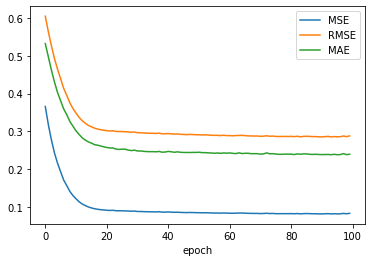

In [39]:
# Plotando os erros obtidos no conjunto de treinamento
# plotamos as três medidas (MSE, RMSE, MAE)
# percebam que depois de 20 épocas, não há uma redução significativa nos erros, 
#e o treinamento poderia ser feito com uma quantidade menor de iterações

# checar os nomes
#print(history.history.keys())

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.xlabel('epoch')
plt.legend(['MSE', 'RMSE', 'MAE'], loc='upper right')
plt.show()

In [40]:
# Realizando as predições nos conjuntos de treino/teste

# predição no conjunto de trienamento
trainPredict = model.predict(trainX)

# predição no conjunto de teste
testPredict  = model.predict(testX)

In [41]:
print("Predição do Teste:")
print(testPredict)

print("\nDF = [Real | Predito]")
np.column_stack((testY, testPredict))


Predição do Teste:
[[ 0.00419462]
 [-0.23923856]
 [ 0.0763329 ]
 [-0.12269209]]

DF = [Real | Predito]


array([[ 0.02470243,  0.00419462],
       [ 1.        , -0.23923856],
       [ 0.26532793,  0.0763329 ],
       [ 0.6420827 , -0.12269209]], dtype=float32)

In [42]:
# Aplicando a inversa da escala para retornar ao valor original
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [43]:
print("\n * Predição do Teste na escala original:")
print(testPredict.shape)
print(testPredict)

#print("\nDF = [Real | Predito]")
#np.column_stack((testY, testPredict))

print("\n * Predição do Teste na escala original:")
print(testY.shape)
print(testY)



 * Predição do Teste na escala original:
(4, 1)
[[401.83014]
 [333.34024]
 [422.12625]
 [366.13055]]

 * Predição do Teste na escala original:
(1, 4)
[[407.60001748 681.99999017 475.30000242 581.29995486]]


In [44]:
# Calculando RMSE no treino e teste
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Treino: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Teste Score: %.2f RMSE' % (testScore))

Treino: 80.12 RMSE
Teste Score: 206.59 RMSE


In [45]:
# Ajustando o plot do treino
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[janela_previsao:len(trainPredict)+janela_previsao, :] = trainPredict
print(trainPredictPlot)

[[      nan]
 [257.60266]
 [203.38457]
 [218.64816]
 [193.28696]
 [217.45132]
 [212.4941 ]
 [240.7287 ]
 [237.26819]
 [222.8556 ]
 [194.61543]
 [295.01495]
 [219.85292]
 [223.51477]
 [204.80232]
 [230.59605]
 [261.335  ]
 [222.24248]
 [268.44797]
 [237.975  ]
 [277.23206]
 [269.9704 ]
 [340.55273]
 [256.84106]
 [298.17853]
 [296.75992]
 [349.9236 ]
 [283.83505]
 [349.38647]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]]


In [46]:
# Ajustando o plot do teste
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(janela_previsao*2)+1:len(dataset)-1, :] = testPredict
print(testPredictPlot)

[[      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [401.83014]
 [333.34024]
 [422.12625]
 [366.13055]
 [      nan]]


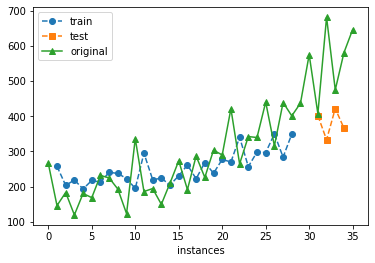

In [47]:
# Ajustando o plot com o sinal original
# - verde   = dataset original
# - azul    = predicoes geradas no conjunto de treinamento
# - laranja = predicoes geradas no conjunto de teste

plt.plot(trainPredictPlot, marker='o', linestyle="--")
plt.plot(testPredictPlot, marker='s', linestyle="--")
plt.plot(scaler.inverse_transform(dataset), marker='^')
plt.xlabel('instances')
plt.legend(['train', 'test', 'original'], loc='upper left')
plt.show()